In [1]:
!apt-get update && apt-get upgrade -y
!apt install -y libgl1-mesa-dev
!apt install -y libglib2.0-0

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease                         
Hit:6 http://security.ubuntu.com/ubuntu focal-security InRelease               
Hit:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Calculating upgrade... Done
The following packages have been kept back:
  libnvinfer-plugin7 libnvinfer7
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-dev is alrea

In [2]:
!pip install opencv-python
!pip install tqdm
!pip install scikit-learn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
!nvidia-smi

Mon Dec 19 04:11:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 36%   31C    P8    19W / 340W |     17MiB / 10240MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from IPython.display import Image, display

In [5]:
from matplotlib import pyplot as plt

In [6]:
import cv2
from PIL import ImageFile
from PIL import Image

In [7]:
import keras
from keras.models import load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

In [8]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [9]:
import random
import tqdm
import glob
import pickle

In [10]:
from datetime import datetime

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
import sys
import pathlib
import os
import shutil
import math
import time

In [13]:
import numpy as np

In [14]:
window_width = 256
window_height = 256
model_name="00/scannoise_remover_model"
era_name="00/scannoise_remover_era"
era = 4
epoch = 31
random.seed(8)

In [26]:
# split noised data to training and test (validation) sets
ERA_X=[]
era_pickle_file_current=era_name + '.' + str(era).zfill(3) +'.current.pickle'
with open(era_pickle_file_current, mode='rb') as f:
    ERA_X = pickle.load(f)
print("current era has ", len(ERA_X), "images")

ERA_X_NEXT=[]
era_pickle_file_nextcal=era_name + '.' + str(era).zfill(3) +'.nextcal.pickle'
with open(era_pickle_file_nextcal, mode='rb') as f:
    ERA_X_NEXT = pickle.load(f)
print("not yet calculated ", len(ERA_X_NEXT), "images")

numof_total_files = len(ERA_X_NEXT)
numof_next_era_x_candidates= int(numof_total_files * 0.02)
    
X_next, x_test= train_test_split(ERA_X_NEXT, test_size=numof_next_era_x_candidates, random_state=42) #from sklearn
print("candidates of images to be added to next era", len(x_test))
random.shuffle(x_test)
y_test = [s.replace('noised', 'clean') for s in x_test]

current era has  42070 images
not yet calculated  814004 images
candidates of images to be added to next era 16280


In [16]:
X_test = np.array([np.array(Image.open(file)) for file in x_test])
Y_test = np.array([np.array(Image.open(file)) for file in y_test])
X_test = X_test.astype('float32')
X_test /= 255
Y_test = Y_test.astype('float32')
Y_test /= 255

In [17]:
# definition to show original image and reconstructed image
def showOrigDec(orig, noise, denoise, num=5):
    import matplotlib.pyplot as plt
    n = num
    m = 6
    plt.figure(dpi=600)  #figsize=(20, 6))

    for i in range(n):
        # display original
        ax = plt.subplot(m, n, i+1)
        _orig = np.copy(orig[i])
        _orig *= 255
        _orig = _orig.astype('uint8')
        plt.imshow(_orig.reshape(window_height, window_width, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # sobel of clean image
        ax = plt.subplot(m, n, i + 1 + n)
        kernel = np.ones((5,5),np.float32)/25
        __orig = cv2.filter2D(_orig,-1,kernel)
        sobelx64f = cv2.Sobel(__orig,cv2.CV_64F,1,0,ksize=5)
        abs_sobel64f = np.absolute(sobelx64f)
        sobel_8u = np.uint8(abs_sobel64f)
        plt.imshow(sobel_8u.reshape(window_height, window_width, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)        
        
        # display noisy image
        ax = plt.subplot(m, n, i + 1 + 2*n)
        _noise = np.copy(noise[i])
        _noise *= 255
        _noise = _noise.astype('uint8')
        plt.imshow(_noise.reshape(window_height, window_width, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # sobel of noisy image
        ax = plt.subplot(m, n, i + 1 + 3*n)
        kernel = np.ones((5,5),np.float32)/25
        __noise = cv2.filter2D(_noise,-1,kernel)
        sobelx64f = cv2.Sobel(__noise,cv2.CV_64F,1,0,ksize=5)
        abs_sobel64f = np.absolute(sobelx64f)
        sobel_8u = np.uint8(abs_sobel64f)
        plt.imshow(sobel_8u.reshape(window_height, window_width, 3)) 
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display the denoised image
        ax = plt.subplot(m, n, i +1 + 4*n)
        _denoise = np.copy(denoise[i])
        _denoise *= 255
        _denoise = _denoise.astype('uint8')
        plt.imshow(_denoise.reshape(window_height, window_width, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display diff between the original and the denoised image
        ax = plt.subplot(m, n, i +1 + 5*n)
        img_diff = _denoise.astype(int) - _noise.astype(int)
        img_diff_abs = np.abs(img_diff)
        img_diff_abs_norm = np.uint8(img_diff_abs / img_diff_abs.max() * 255)
        plt.imshow(img_diff_abs_norm.reshape(window_height, window_width, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()

In [18]:
model = load_model(model_name + '.era_' + str(era).zfill(3) + '.epoch_'+ str(epoch).zfill(3) + '.h5')
model.summary()
with tf.device('/cpu:0'):
    score = model.evaluate(X_test, Y_test)
    print(type(score))
    magazine_test = model.predict(X_test)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 activation (Activation)     (None, 256, 256, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 64)     256       
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 256, 256, 64)      0         
                                                             

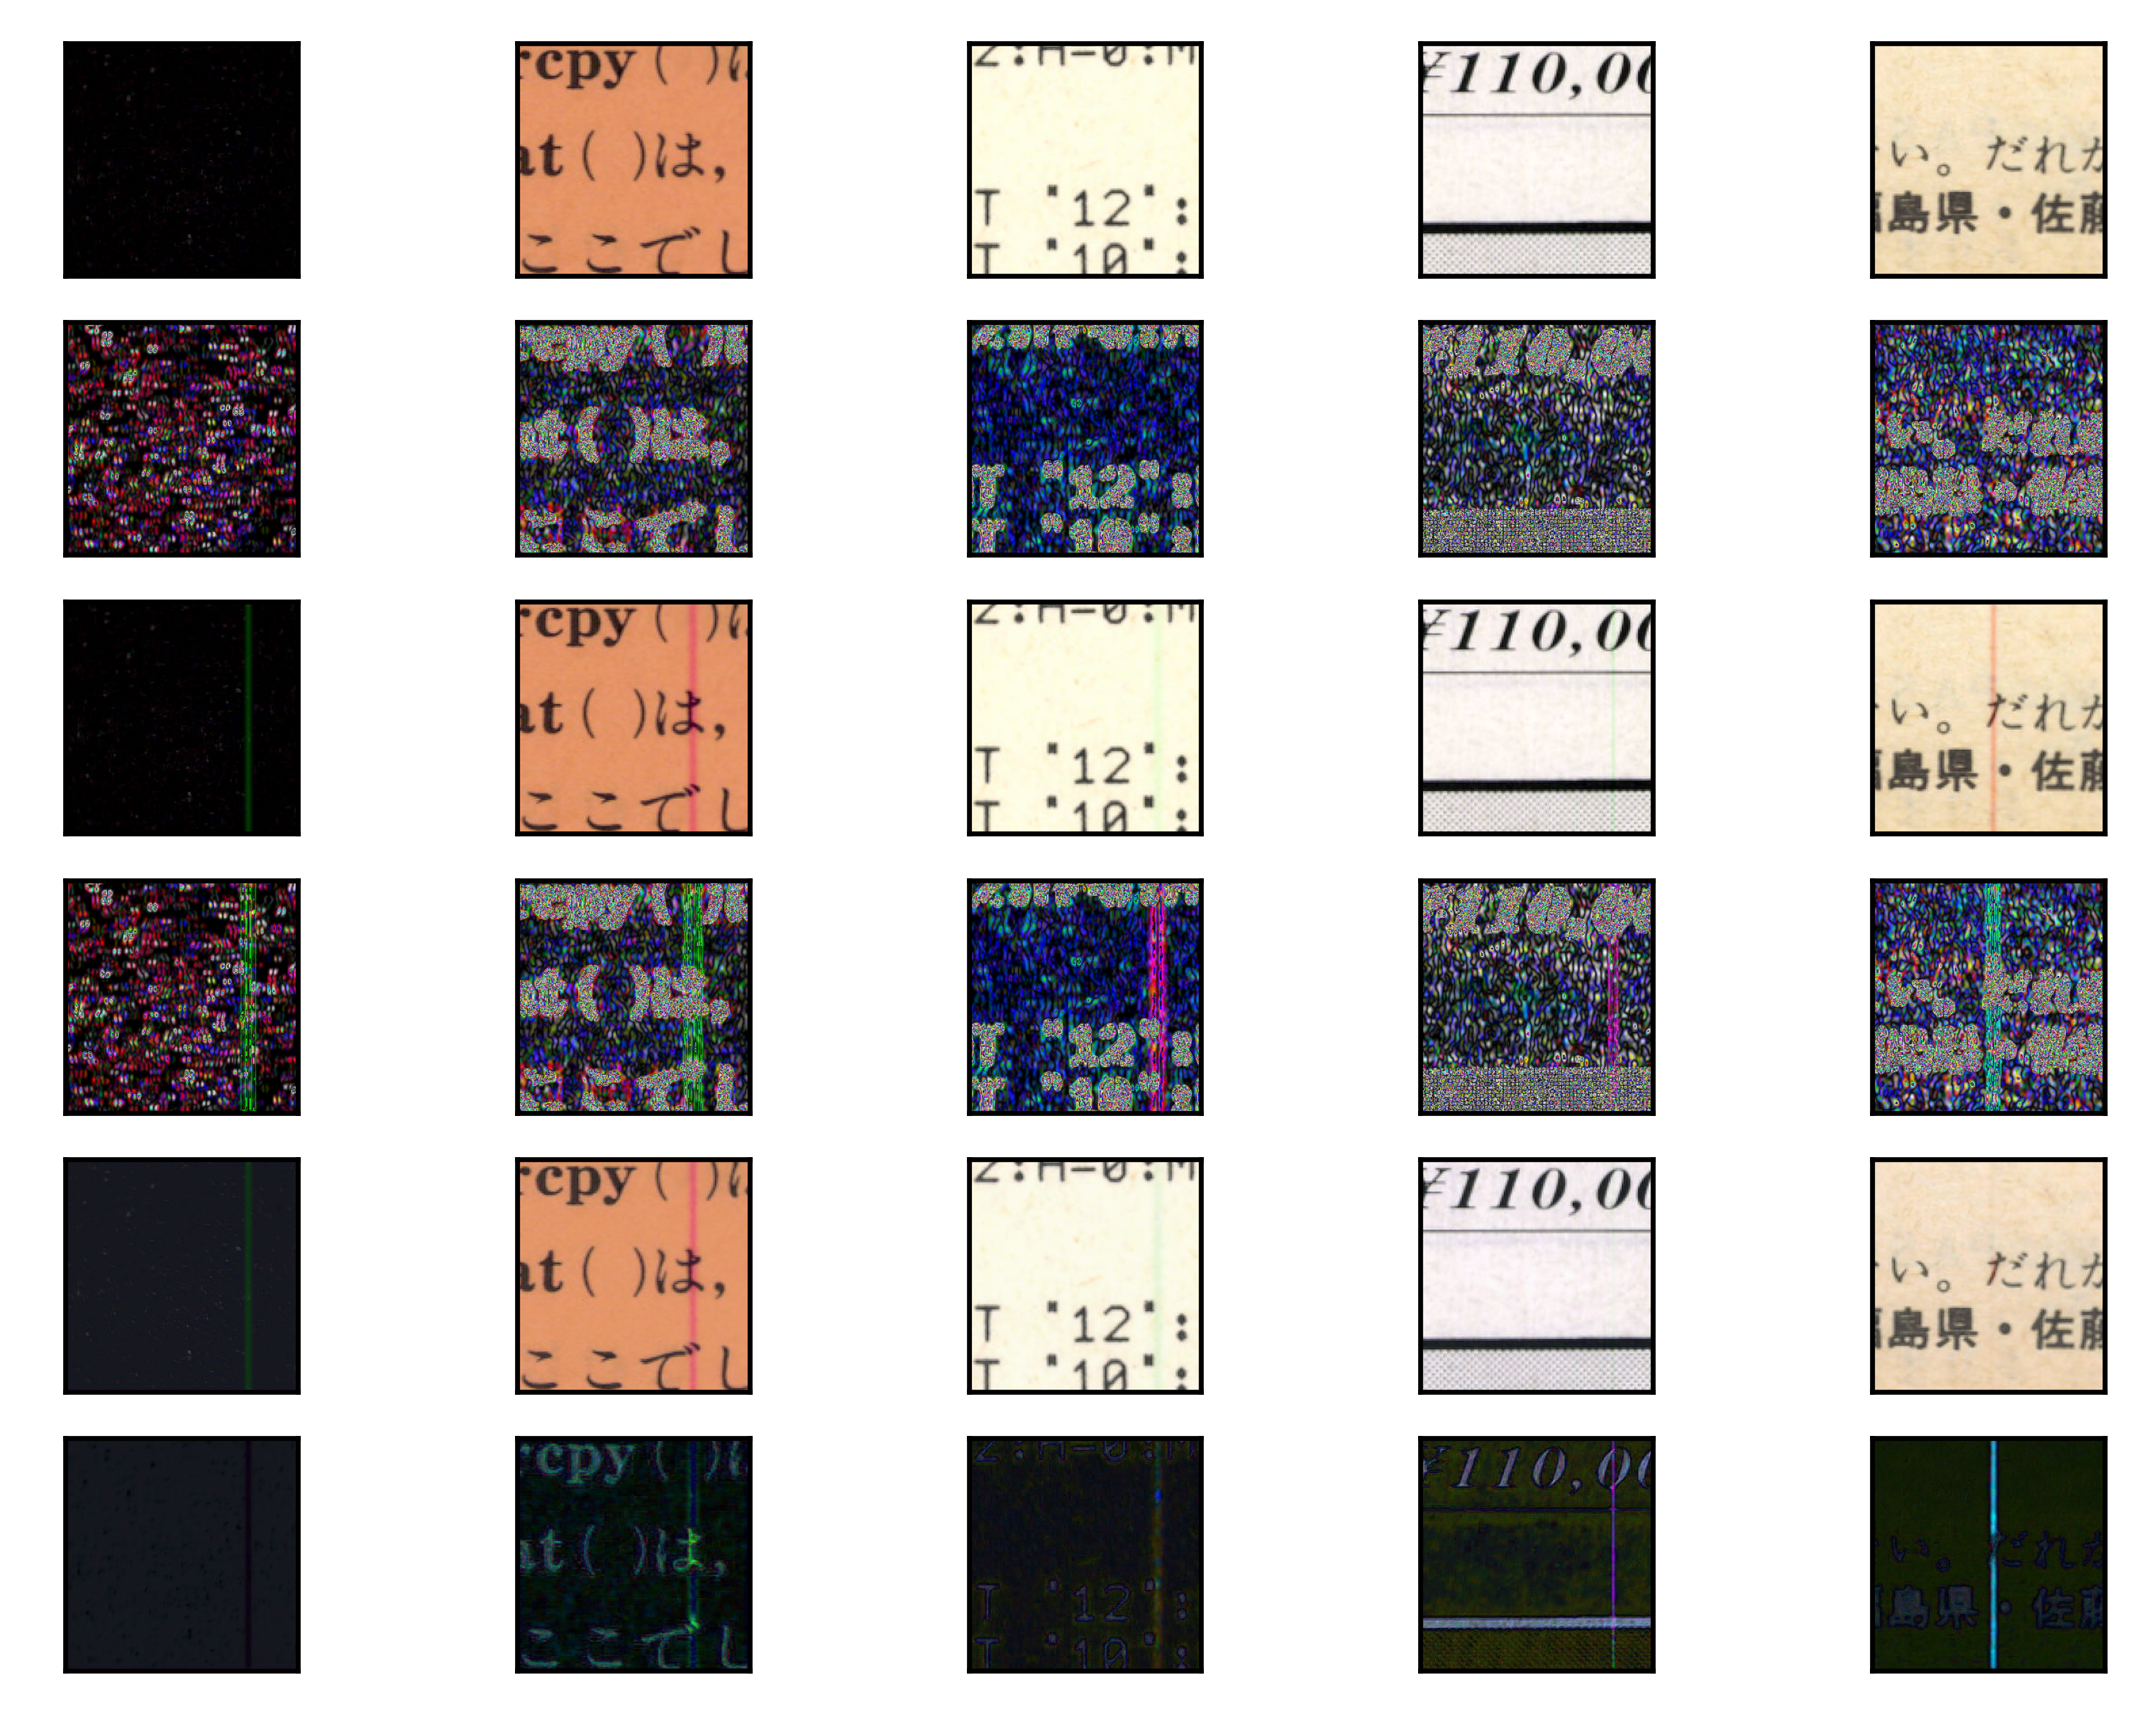

In [19]:
#for i in range(int(len(magazine_test)/5)):
#    showOrigDec(Y_test[i*5:], X_test[i*5:], magazine_test[i*5:])
showOrigDec(Y_test[339:], X_test[339:], magazine_test[339:])

In [27]:
era_diffname=era_name + '.' + str(era+1).zfill(3) +'.diff.txt'
psnr_orig = np.arange(len(magazine_test)).astype('float')
psnr_denoised = np.arange(len(magazine_test)).astype('float')
psnr_diff = np.arange(len(magazine_test)).astype('float')
not_improved = 0
with open(era_diffname, mode='w') as f:        
    for i in range(len(magazine_test)):
        orig_img = np.array(Y_test[i])
        orig_img *= 255
        orig_img = orig_img.astype('uint8')
        _orig_img= orig_img.copy()
        _orig_img= _orig_img.astype('int64')
    
        noised_img = np.array(X_test[i])
        noised_img *= 255
        noised_img = noised_img.astype('uint8')
        _noised_img= noised_img.copy()
        _noised_img= _noised_img.astype('int64')

        denoised_img = np.array(magazine_test[i])
        denoised_img *= 255
        denoised_img = denoised_img.astype('uint8')
        _denoised_img= denoised_img.copy()
        _denoised_img= _denoised_img.astype('int64')    
    
        orig_img_rgbadd = _orig_img[:,:,0]+_orig_img[:,:,1]+_orig_img[:,:,2]
        noised_img_rgbadd = _noised_img[:,:,0]+_noised_img[:,:,1]+_noised_img[:,:,2]
        denoised_img_rgbadd = _denoised_img[:,:,0]+_denoised_img[:,:,1]+_denoised_img[:,:,2]

        diff_orig2noise = np.abs(noised_img_rgbadd - orig_img_rgbadd).sum()
        diff_orig2denoise = np.abs(denoised_img_rgbadd - orig_img_rgbadd).sum()
        psnr_orig[i] = cv2.PSNR(orig_img, noised_img)
        psnr_denoised[i] = cv2.PSNR(orig_img, denoised_img)

        psnr_diff[i] = psnr_denoised[i] - psnr_orig[i]
        print("image#: ",i ,"diff_orig2noise: ", diff_orig2noise, " diff_orig2denoise: ", diff_orig2denoise, 
              "psnr_orig: ", psnr_orig[i], " psnr_denoised: ", psnr_denoised[i], " psnr_diff: ",psnr_diff[i]  ,file=f)

        if (psnr_diff[i] < 0.0): #not improved 
            ERA_X.append(x_test[i])
            ERA_X_NEXT.remove(x_test[i])
            not_improved = not_improved + 1
print("the number of images not imporved by DnCNN: ", not_improved)
index=[i[0] for i in sorted(enumerate(psnr_diff), key=lambda x:x[1])]

the number of images not imporved by DnCNN:  13744


In [32]:
#for i in range(int(len(magazine_test)/5)):
#    showOrigDec(Y_test[index[i*5:]], X_test[index[i*5:]], magazine_test[index[i*5:]])

In [28]:
era_pickle_file_current=era_name + '.' + str(era+1).zfill(3) +'.current.pickle'
era_pickle_file_nextcal=era_name + '.' + str(era+1).zfill(3) +'.nextcal.pickle'

with open(era_pickle_file_current, mode='wb') as f:
     pickle.dump(ERA_X, f)
with open(era_pickle_file_nextcal, mode='wb') as f:
     pickle.dump(ERA_X_NEXT, f)

In [29]:
print(len(ERA_X))

55814


In [30]:
print(len(ERA_X_NEXT))

800260
